# Data Cleaning

In [1]:
import pandas as pd

In [3]:
'''get data files from LOCAL FOLDER'''
path_orderlines = './data_original/orderlines.csv'
path_brands     = './data_original/brands.csv'
path_orders     = './data_original/orders.csv'
path_products   = './data_original/products.csv'

In [4]:
# read original dfs
orderlines_df   = pd.read_csv(path_orderlines)
brands_df       = pd.read_csv(path_brands)
orders_df       = pd.read_csv(path_orders)
products_df     = pd.read_csv(path_products)

#create copy dfs to work with:
orderlines  = orderlines_df.copy()
brands      = brands_df.copy()
orders      = orders_df.copy()
products    = products_df.copy()

## Remove Duplicates

Check for duplicates.

In [5]:
print(orders.duplicated().sum())
print(orderlines.duplicated().sum())
print(products.duplicated().sum())
print(brands.duplicated().sum())

0
0
8746
0


Only products contains duplicates. Remove them!

In [6]:
products = products.drop_duplicates()
products.duplicated().sum()

0

## Missing values

### orders

In [7]:
orders.isna().value_counts()

order_id  created_date  total_paid  state
False     False         False       False    226904
                        True        False         5
Name: count, dtype: int64

Only total_paid contains a few missing values. Simply delete them:

In [8]:
orders = orders.loc[~orders.total_paid.isna(), :]
orders.total_paid.isna().sum()

0

### orderlines

there are no missing values in orderlines:

In [9]:
orderlines.isna().value_counts()

id     id_order  product_id  product_quantity  sku    unit_price  date 
False  False     False       False             False  False       False    293983
Name: count, dtype: int64

### brands

there are no missing values in brands:

In [10]:
brands.isna().value_counts()

short  long 
False  False    187
Name: count, dtype: int64

### products

In [11]:
products.isna().value_counts()

sku    name   desc   price  promo_price  in_stock  type 
False  False  False  False  False        False     False    10477
                                                   True        50
                     True   False        False     False       46
              True   False  False        False     False        7
Name: count, dtype: int64

desc, price and type contain nans. clean them one after the other.

#### desc

In [12]:
products.loc[products.desc.isna()]

,sku,name,desc,price,promo_price,in_stock,type
16126,WDT0211-A,"Open - Purple 2TB WD 35 ""PC Security Mac hard ...",NaN,107,814.659,0,1298
16128,APP1622-A,Open - Apple Smart Keyboard Pro Keyboard Folio...,NaN,1.568.206,1.568.206,0,1298
17843,PAC2334,Synology DS718 + NAS Server | 10GB RAM,NaN,566.35,5.659.896,0,12175397
18152,KAN0034-A,Open - Kanex USB-C Gigabit Ethernet Adapter Ma...,NaN,29.99,237.925,0,1298
18490,HTE0025,Hyper Pearl 1600mAh battery Mini USB Mirror an...,NaN,24.99,22.99,1,1515
18612,OTT0200,OtterBox External Battery Power Pack 20000 mAHr,NaN,79.99,56.99,1,1515
18690,HOW0001-A,Open - Honeywell thermostat Lyric zonificador ...,NaN,199.99,1.441.174,0,11905404


Simply impute product.name to the missing entries in desc:

In [13]:
products.loc[products['desc'].isna(), 'desc'] = products.loc[products['desc'].isna(), 'name']

#### price

Delete the rows with missing values in price:

In [14]:
products = products.dropna(subset=['price'])

#### type

It is unknown what the type column means, so we delete the entire column:

**NO! might be needed later!**

In [15]:
#products = products.drop(['type'], axis=1)

## Datatypes

### orders

In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226904 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      226904 non-null  int64  
 1   created_date  226904 non-null  object 
 2   total_paid    226904 non-null  float64
 3   state         226904 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 8.7+ MB


created_date should be datetime:

In [17]:
orders["created_date"] = pd.to_datetime(orders["created_date"])

### orderlines

In [18]:
orderlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                293983 non-null  int64 
 1   id_order          293983 non-null  int64 
 2   product_id        293983 non-null  int64 
 3   product_quantity  293983 non-null  int64 
 4   sku               293983 non-null  object
 5   unit_price        293983 non-null  object
 6   date              293983 non-null  object
dtypes: int64(4), object(3)
memory usage: 15.7+ MB


date should be a datetime datatype:


In [19]:
orderlines["date"] = pd.to_datetime(orderlines["date"])
orderlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                293983 non-null  int64         
 1   id_order          293983 non-null  int64         
 2   product_id        293983 non-null  int64         
 3   product_quantity  293983 non-null  int64         
 4   sku               293983 non-null  object        
 5   unit_price        293983 non-null  object        
 6   date              293983 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 15.7+ MB


unit_price should be a float datatype. it also contains strange numbers that need to be fixed before conversion.

In [20]:
orderlines.unit_price.str.contains("\d+\.\d+\.\d+").value_counts()

unit_price
False    257814
True      36169
Name: count, dtype: int64

Either delete all corrupted rows, or try to fix it:

In [21]:
# delete corrupted rows:
two_dot_order_ids_list = orderlines.loc[orderlines.unit_price.str.contains("\d+\.\d+\.\d+"), "id_order"]
orderlines = orderlines.loc[~orderlines.id_order.isin(two_dot_order_ids_list)]

In [22]:
# fix A
#orderlines['unit_price_fixed'] = pd.to_numeric(orderlines['unit_price'].str.replace('.', ''))/100

In [23]:
# fix B
#...

In [24]:
orderlines["unit_price"] = pd.to_numeric(orderlines["unit_price"])

### brands

brands datatypes are correct.

In [25]:
brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   short   187 non-null    object
 1   long    187 non-null    object
dtypes: object(2)
memory usage: 3.1+ KB


### products

In [26]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10534 entries, 0 to 19325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          10534 non-null  object
 1   name         10534 non-null  object
 2   desc         10534 non-null  object
 3   price        10534 non-null  object
 4   promo_price  10534 non-null  object
 5   in_stock     10534 non-null  int64 
 6   type         10484 non-null  object
dtypes: int64(1), object(6)
memory usage: 658.4+ KB


The price column contains corrupted data, like more than one dot within the price values. We can either try to fix that problem or simply delete all affected rows.

In [27]:
# delete corrupted rows:
products = products.loc[
    (~products.price.astype(str).str.contains("\d+\.\d+\.\d+")) # look for two dots
    & (~products.price.astype(str).str.contains("\d+\.\d{3,}")) # look for more than 2 decimals
    , :]

In [28]:
# fix:
#...

In [29]:
# Convert price column from object to float datatype
products["price"] = pd.to_numeric(products["price"])

The promo_price column is totally messy, best is to delete it altogether:

In [30]:
# remove promo price column
products = products.drop(columns=["promo_price"])

Products looks good now:

In [31]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9992 entries, 0 to 19325
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sku       9992 non-null   object 
 1   name      9992 non-null   object 
 2   desc      9992 non-null   object 
 3   price     9992 non-null   float64
 4   in_stock  9992 non-null   int64  
 5   type      9946 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 546.4+ KB


In [32]:
products.describe()

,price,in_stock
count,9992.000000,9992.000000
mean,667.346268,0.199359
std,1365.540546,0.399539
min,2.990000,0.000000
25%,42.990000,0.000000
50%,112.990000,0.000000
75%,660.695000,0.000000
max,15339.000000,1.000000


 All the data tables have been cleaned. Proceed to do some cross-validation in order to get rid of inconsistencies and to improve the overall quality of the data.

# Data Quality Checks and Improvement

## Exclude unwanted orders

In [33]:
orders.state.value_counts()

state
Shopping Basket    117809
Completed           46605
Place Order         40883
Pending             14374
Cancelled            7233
Name: count, dtype: int64

Meaning of orders.state values:

“Shopping basket” – products have been placed in the shopping basket

“Place Order” – the order has been placed, but is awaiting shipment details

“Pending” – the order is awaiting payment confirmation

“Completed” – the order has been placed and paid, and the transaction is completed.

“Cancelled” – the order has been cancelled and the payment returned to the customer.

Not all of those are needed for the analysis and therefore should be excluded now:

In [34]:
# uncomment states to keep
orders_to_keep = [
                  #'Shopping Basket',
                  #'Place Order',
                  #'Pending',
                  'Completed']

In [35]:
orders = orders.loc[orders.state.isin(orders_to_keep)]

## Keep only orders present in both orders and orderlines

Keep only rows with orderlines.id_order present in orders.order_id:

In [36]:
orderlines = orderlines.loc[orderlines.id_order
                            .isin(orders.order_id.unique())]

Keep only rows with orders.order_id present in orderlines.id_order:

In [37]:
orders = orders.loc[orders.order_id.isin(orderlines.id_order.unique())]

Now both tables have an identical number of unique ids:

In [38]:
print(orders.order_id.nunique())
print(orderlines.id_order.nunique())

43064
43064


## Exclude orders with unknown products

In [39]:
orderlines.sku.isin(products.sku.unique()).value_counts()

sku
True     55320
False     1394
Name: count, dtype: int64

Above shows that some sku numbers in orderlines don't appear in products. This means that these products are unknown and should be removed.

First create a list with unknown products:

In [40]:
ids_unknown_products = orderlines[~orderlines.sku.isin(products.sku.unique())]['id_order']

Then exclude rows involving unknown products from orders and orderlines:

In [41]:
orders = orders[~orders.order_id.isin(ids_unknown_products)]
orderlines = orderlines[~orderlines.id_order.isin(ids_unknown_products)]

In [42]:
# Consistency checks

# order_id is not in id_order: should be empty
#orders[~orders.order_id.isin(orderlines.id_order.unique())]

# id_order is not in order_id: should be empty
#orderlines[~orderlines.id_order.isin(orders.order_id.unique())]

In [43]:
print(orders.order_id.nunique())
print(orderlines.id_order.nunique())

41701
41701


Looks good!

## Compare the revenue from different tables

### Step 1: Add unit_price_total column to orderlines

In [44]:
orderlines['unit_price_total'] = orderlines.product_quantity * orderlines.unit_price

In [45]:
orderlines.head()

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total
7,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,47.49
8,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,18.99
9,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,72.19
18,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14,60.90
24,1119145,299561,0,1,PEB0015,142.49,2017-01-01 02:38:50,142.49


### Step 2: Group by id_order

In [46]:
grouped_orderlines = orderlines.groupby('id_order')[['unit_price_total']].sum()
grouped_orderlines.head()

,unit_price_total
id_order,
241423,129.16
242832,10.77
243330,77.99
245275,149.00
245595,105.98


### Step 3: Merge with orders and calculate price diff

In [47]:
orders = orders.merge(grouped_orderlines,
                      how='left',
                      left_on='order_id', right_on='id_order')

In [48]:
orderlines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54324 entries, 7 to 293661
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                54324 non-null  int64         
 1   id_order          54324 non-null  int64         
 2   product_id        54324 non-null  int64         
 3   product_quantity  54324 non-null  int64         
 4   sku               54324 non-null  object        
 5   unit_price        54324 non-null  float64       
 6   date              54324 non-null  datetime64[ns]
 7   unit_price_total  54324 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 3.7+ MB


In [49]:
orders['price_diff'] = (orders['total_paid']
                        - orders['unit_price_total']
                        ).round(2)

In [50]:
orders.price_diff.describe()

count    41701.000000
mean         4.474808
std         26.046478
min       -165.000000
25%          0.000000
50%          4.990000
75%          6.990000
max       3984.990000
Name: price_diff, dtype: float64

The price diff contains few extremely low and high values. These can be considered as outliers and excluded from further analysis.
A value is considered an outlier if it is
+ lower than the 25% quartile - (1.5 x interquartile range)
+ higher than the 75% quartile + (1.5 x interquartile range)

In [51]:
# calculate the quartiles
Q1 = orders.price_diff.quantile(0.25)
Q3 = orders.price_diff.quantile(0.75)

# calculate the interquartile range
IQR = Q3-Q1

# filter the DataFrame to include only "non-outliers"
orders_no_outliers = orders.loc[(orders.price_diff >= (Q1 - 1.5*IQR))
                                & (orders.price_diff <= (Q3 + 1.5*IQR))]

In [52]:
print(Q1 - 1.5*IQR, Q3 + 1.5*IQR)

-10.485 17.475


<Axes: >

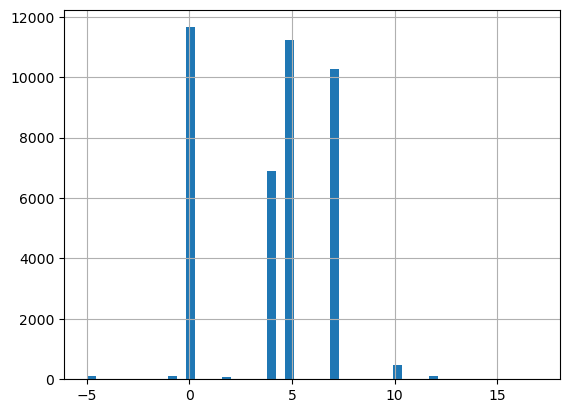

In [53]:
orders_no_outliers.price_diff.hist(bins=50)

In [54]:
orders_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40985 entries, 0 to 41700
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_id          40985 non-null  int64         
 1   created_date      40985 non-null  datetime64[ns]
 2   total_paid        40985 non-null  float64       
 3   state             40985 non-null  object        
 4   unit_price_total  40985 non-null  float64       
 5   price_diff        40985 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 2.2+ MB


The orders with outliers need to be removed from orderlines as well:

In [55]:
orderlines_no_outliers = orderlines.loc[orderlines.id_order
                                        .isin(orders_no_outliers.order_id)]

In [56]:
# consistency check
len(orders_no_outliers["order_id"].unique()), len(orderlines_no_outliers["id_order"].unique())

(40985, 40985)

In [57]:
orderlines_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53231 entries, 7 to 293661
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                53231 non-null  int64         
 1   id_order          53231 non-null  int64         
 2   product_id        53231 non-null  int64         
 3   product_quantity  53231 non-null  int64         
 4   sku               53231 non-null  object        
 5   unit_price        53231 non-null  float64       
 6   date              53231 non-null  datetime64[ns]
 7   unit_price_total  53231 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 3.7+ MB


Save the cleaned files:

In [58]:
orders_no_outliers.to_csv("./data_cleaned/orders_qu.csv", index=False)
orderlines_no_outliers.to_csv("./data_cleaned/orderlines_qu.csv", index=False)
products.to_csv('./data_cleaned/products_qu.csv', index=False)
brands.to_csv('./data_cleaned/brands_qu.csv', index=False)